In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from utils.cli_kaggle import get_kagglke_data
plt.style.use('classic')

In [2]:
# get_kagglke_data("mirichoi0218/insurance", "./data/")
df = pd.read_csv('data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<a href=https://www.kaggle.com/datasets/mirichoi0218/insurance>Medical Cost Personal Datasets</a> <br>
Column descriptions:
- **age**: age of primary beneficiary
- **sex**: insurance contractor gender, female, male
- **bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight ($kg / m ^ 2$) using the ratio of height to weight, ideally 18.5 to 24.9
- **children**: Number of children covered by health insurance / Number of dependents
- **smoker**: Smoking
- **region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- **charges**: Individual medical costs billed by health insurance

Assume that we observe only non-smoking women. <br>
We only know their age and insurance charges. <br>
We want to estimate insurance cost for not smoking women at age 30. <p>
*The baseline assumption*: there is a fixed cost of insurance and personal coefficient of age, i.e. <br>
$\widehat{\text{Charge}} = \widehat{\text{Fixed Cost}} + \hat k \times \text{Age}$

Or in general: <br>
$\hat Y = \hat\beta_0 + \hat\beta_1 x_1 + ... + \hat\beta_n x_n = X\hat\beta$ <br>
*where:* <br>
$ 
X = 
 \begin{pmatrix}
  x_{1,1} & x_{1,2} & \cdots & x_{1,n} & 1 \\
  x_{2,1} & x_{2,2} & \cdots & a_{2,n} & 1  \\
  \vdots  & \vdots  & \ddots & \vdots & \vdots  \\
  x_{m,1} & x_{m,2} & \cdots & x_{m,n} & 1 
 \end{pmatrix},
\hat\beta = \begin{pmatrix}
    \hat\beta_1 \\
    \vdots  \\
    \hat\beta_n \\
    \hat\beta_0
\end{pmatrix}$

In [12]:
female_not_smokers_sample = df.query("sex=='female' and smoker=='no'").sample(25, random_state=42)
fnss = female_not_smokers_sample.copy()

In [13]:
x1 = fnss.age.to_numpy()
x2 = np.ones(shape=len(x1))
X = np.array([x1, x2]).T
y = fnss.charges.to_numpy()

# I suppose beta_0 is -4500 and beta_1 is 300
weights = np.array([300, -4500])
# Use formula above
y_pred = X@weights

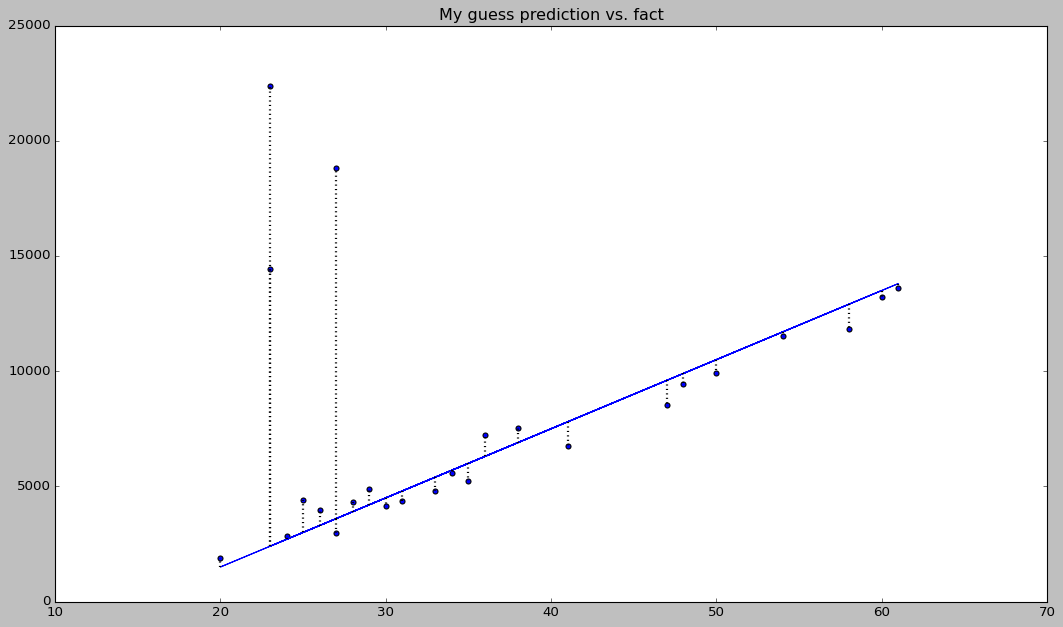

In [14]:
plt.figure(figsize=(16, 9))
plt.title('My guess prediction vs. fact')
plt.plot(x1, y_pred)
plt.scatter(x1, y)
for xi, yi, ypi in zip(x1, y, y_pred):
    plt.plot([xi, xi], [ypi, yi], linestyle=':', linewidth=2, color='black')
plt.show()

The prediction looks reasonable, but it can be improved.  
To do this, we need to minimize the prediction error.

Two common error metrics are:

- Mean Absolute Error: $ MAE=\frac{1}{n} \displaystyle\sum_{i=1}^{n} |y_i-\hat y_i|=\frac{1}{n} \displaystyle\sum_{i=1}^{n} |e_i|$

- Mean Squared Error: $ MSE=\frac{1}{n} \displaystyle\sum_{i=1}^{n} (y_i-\hat y_i)^2=\frac{1}{n} \displaystyle\sum_{i=1}^{n} e_i^2 $

MAE is the L1 norm of the error vector divided by \(n\), and MSE is the squared L2 norm divided by \(n\):

- $MAE = \frac{1}{n}||e|| $

- $MSE = \frac{1}{n}||e||_2^2 $

In [15]:
print('MAE', np.linalg.norm(y_pred - y, 1)/len(y))
print('MSE', (np.linalg.norm(y_pred - y, 2)**2)/len(y))

MAE 2410.6268636
MSE 31433766.67521436


Here is classic formula for $ \beta $ considering the minimum of MSE:
$$
\hat\beta = (X^TX)^{-1}X^Ty.
$$

There is no closed-form solution for minimizing MAE, so the problem is typically solved using numerical optimization methods such as gradient descent.

[ 126.69088136 3588.82666066]


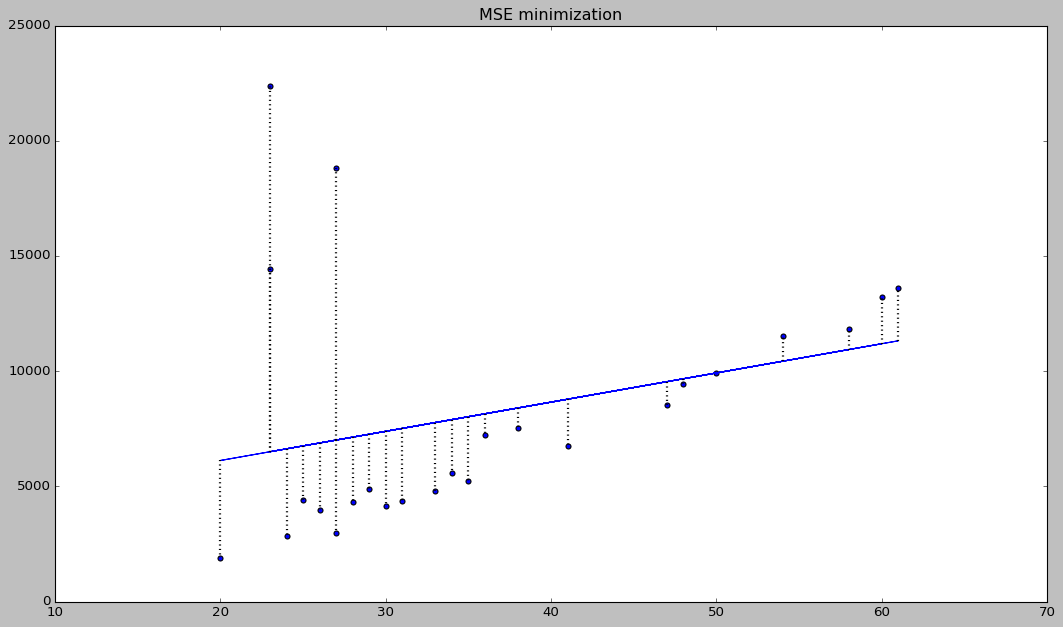

In [16]:
# MSE
beta = np.linalg.inv(X.T@X)@X.T@y
print(beta)
y_pred_mse = X@beta

plt.figure(figsize=(16, 9))
plt.title('MSE minimization')
plt.plot(x1, y_pred_mse)
plt.scatter(x1, y)
for xi, yi, ypi in zip(x1, y, y_pred_mse):
    plt.plot([xi, xi], [ypi, yi], linestyle=':', linewidth=2, color='black')
plt.show()

In [17]:
def lr_mae(X: np.array, y: np.array, w: np.array) -> float:
    """
    Calculates MAE
    Parameters:
        X: matrix of features
        y: array of outcomes
        w: weights for linear regression
    """
    y_pred = X@w
    return np.linalg.norm(y_pred - y, 1)/len(y)

def lr_mse(X: np.array, y: np.array, w: np.array) -> float:
    """
    Calculates MSE
    Parameters:
        X: matrix of features
        y: array of outcomes
        w: weights for linear regression
    """
    y_pred = X@w
    return (np.linalg.norm(y_pred - y, 2)**2)/len(y)

def grad(func: function, d: str, **kwargs: dict) -> list:
    """
    Calculates gradient of function
    Parameters:
        func: function to differentiate
        d: name of the parameter of the function by which differentiation will be performed
        kwargs: args of function dict(name: values)
    """
    f_init = func(**kwargs)
    gradient = []
    for n, _ in enumerate(kwargs[d]):
        params_new = dict(kwargs)
        params_new[d] = kwargs[d].copy()
        params_new[d][n] += 1e-8
        f_new = func(**params_new)
        gradient.append((f_new - f_init)/1e-8)
        
    return np.array(gradient)

def gradient_descent(func: function, min_param_name: str, gamma: float=1, max_iter: int=50_000, **kwargs) -> np.array:
    """
    Simple gradient descent
    Parameters:
        func: function to minimization
        min_param_name: name of the parameter of the function by which minimization will be performed
        gamma: the speed of gradient descent
        max_iter: max iterations when minimization will stop
        kwargs: args of function dict(name: values)
    """
    i = 0
    f_old = func(**kwargs)

    kwargs[min_param_name] = kwargs[min_param_name] - grad(func, min_param_name, **kwargs)*gamma
    f_new = func(**kwargs)


    while abs(f_new - f_old) > 1e-8 and i < max_iter:
        f_old = f_new
        kwargs[min_param_name] = kwargs[min_param_name] - grad(func, min_param_name, **kwargs)*gamma
        f_new = func(**kwargs)
        i+=1

    return kwargs[min_param_name]

In [18]:
weights = np.array([300., -4500.])
# I don't know how but gamma=1e-4 gives almost the same answer as analytical formula
weights_opt_mse = gradient_descent(lr_mse, min_param_name='w', gamma=1e-4, max_iter=1_000_000, **{'X': X, 'y': y, 'w': weights})
print('My grad descent:', weights_opt_mse)
print('Formula:', beta)

My grad descent: [ 126.89671218 3580.48821986]
Formula: [ 126.69088136 3588.82666066]


My grad descent for MAE: [  295.4697992  -4499.31762343]


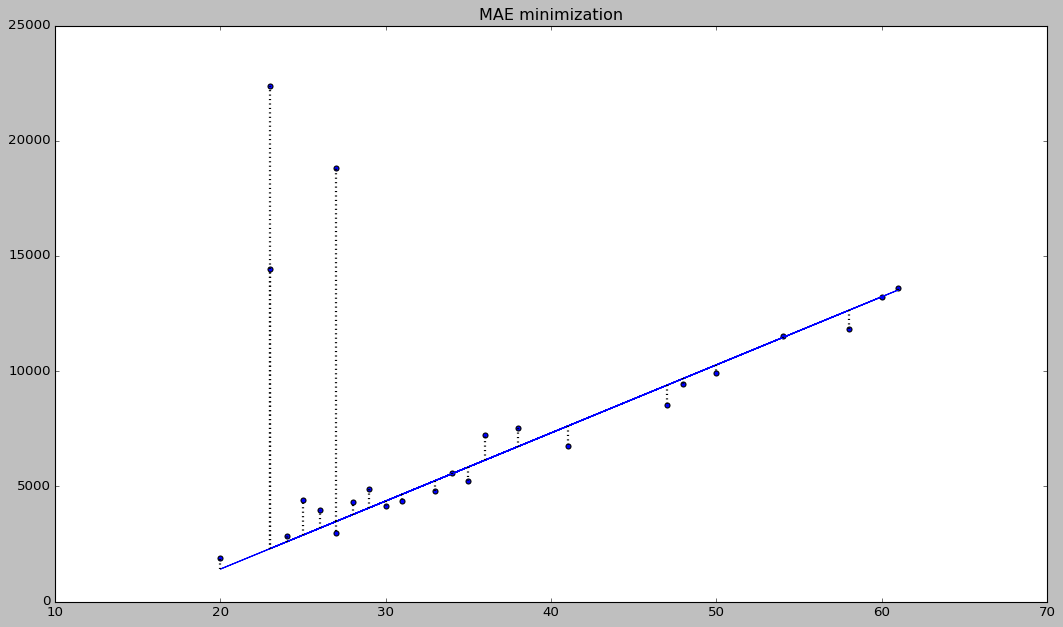

In [19]:
weights = np.array([300., -4500.])
weights_opt_mae = gradient_descent(lr_mae, min_param_name='w', gamma=1e-4, max_iter=1_000_000, **{'X': X, 'y': y, 'w': weights})
print('My grad descent for MAE:', weights_opt_mae)

y_pred = X@weights_opt_mae
plt.figure(figsize=(16, 9))
plt.title('MAE minimization')
plt.plot(x1, y_pred)
plt.scatter(x1, y)
for xi, yi, ypi in zip(x1, y, y_pred):
    plt.plot([xi, xi], [ypi, yi], linestyle=':', linewidth=2, color='black')
plt.show()

When comparing MAE and MSE, it is preferable to use MAE in this case because the dataset contains outliers. <br>
Since MSE penalizes large errors quadratically, extreme observations can dominate the loss and bias the model toward fitting those outliers. <br>
MAE, on the other hand, grows linearly with the error and is therefore more robust.